In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

!pip install orthojax --upgrade
!pip install py-design --upgrade

DEPRECATION: graphql-ws 0.3.0 has a non-standard dependency specifier graphql-core>=2.0<3. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of graphql-ws or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: graphql-ws 0.3.0 has a non-standard dependency specifier graphql-core>=2.0<3. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of graphql-ws or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


# Polynomial Chaos in Many Dimensions

Assume that we have a random vector:

$$
\Xi = (\Xi_1, \dots,\Xi_d),
$$

where $\Xi_i$ are independent random variables. The space of interest is the space of squared integrable functions on the probability space of $\Xi$:

$$
L^2(\Xi) = \left\{ f : \mathbb{R}^d \to \mathbb{R} \mid \int_{\mathbb{R}^d} f(\xi)^2 \, d\mathbb{P}(\xi) < \infty \right\}.
$$

To build an orthonormal basis in $L^2(\Xi)$, we exploit the fact that:

$$
L^2(\Xi) = L^2(\Xi_1) \otimes \dots \otimes L^2(\Xi_d),
$$

where the equality is understood as an isomorphism of Hilbert spaces. We can then build an orthonormal basis in $L^2(\Xi)$ by taking the tensor product of univariate orthonormal bases in $L^2(\Xi_i)$.

Using the multi-index notation, we can write the basis as:

$$
\left\{ \phi_\alpha(\xi) = \prod_{i=1}^d \phi_{\alpha_i}(\xi_i) \mid \alpha \in \mathbb{N}^d_0\right\},
$$

where $\phi_{\alpha_i}$ is the univariate orthonormal basis in $L^2(\Xi_i)$.

Typically, we need to truncate the basis to a finite number of terms. This is done by choosing a maximum degree $\rho$ and taking only the multi-indices $\alpha$ such that $|\alpha| \leq \rho$. 
The truncated basis is then:

$$
\left\{ \phi_\alpha(\xi) = \prod_{i=1}^d \phi_{\alpha_i}(\xi_i) \mid \alpha \in \mathbb{N}^d_0, |\alpha| \leq \rho \right\}.
$$


## Example: Legendre Polynomials in 2D

Let us consider the case where $\Xi_1$ and $\Xi_2$ are independent uniform random variables in $[-1,1]$.
Here is how we can construct the basis in $L^2(\Xi)$:

In [67]:
import orthojax as ojax

degree1 = 3
phi1 = ojax.make_legendre_polynomial(degree1)
degree2 = 3
phi2 = ojax.make_legendre_polynomial(degree2)

total_degree = 6
phi = ojax.TensorProduct(total_degree, [phi1, phi2])

Here are the terms that are used to construct the basis:

In [68]:
print(f"Number of basis functions: {phi.num_basis}")
print("Terms in truncated tensor product:")
for i in range(phi.num_basis):
  print(f"ψ{i} = φ1{phi.terms[i][0]}⊗φ2{phi.terms[i][1]}")

Number of basis functions: 16
Terms in truncated tensor product:
ψ0 = φ10⊗φ20
ψ1 = φ11⊗φ20
ψ2 = φ10⊗φ21
ψ3 = φ12⊗φ20
ψ4 = φ11⊗φ21
ψ5 = φ10⊗φ22
ψ6 = φ13⊗φ20
ψ7 = φ12⊗φ21
ψ8 = φ11⊗φ22
ψ9 = φ10⊗φ23
ψ10 = φ13⊗φ21
ψ11 = φ12⊗φ22
ψ12 = φ11⊗φ23
ψ13 = φ13⊗φ22
ψ14 = φ12⊗φ23
ψ15 = φ13⊗φ23


You can evaluate it as follows:

In [69]:
import numpy as np

xs = np.random.randn(100, 2)
phis = phi(xs)
print(phis.shape)

(100, 16)


Let's plot the first few basis functions:

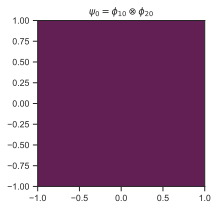

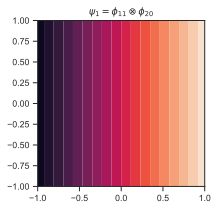

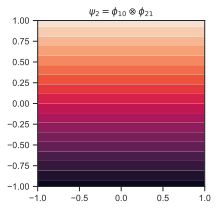

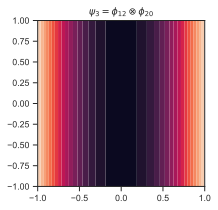

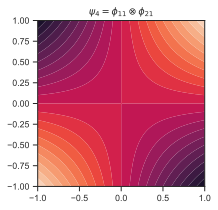

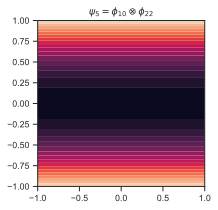

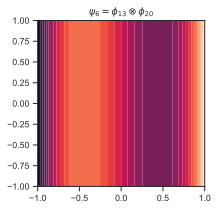

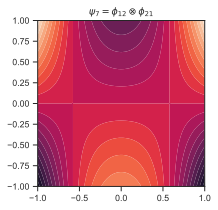

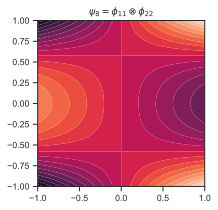

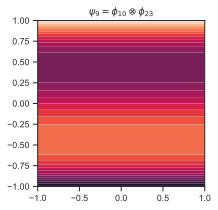

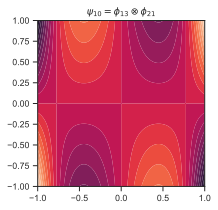

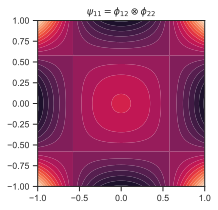

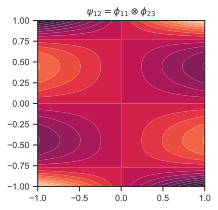

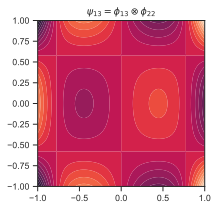

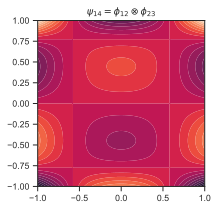

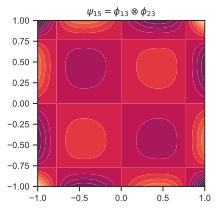

In [70]:
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.stack([X1, X2], axis=-1)
X_flat = np.reshape(X, [-1, 2])
phis = phi(X_flat)
Z = np.reshape(phis, [100, 100, phi.num_basis])

for i in range(phi.num_basis):
  fig, ax = plt.subplots(figsize=(3, 3))
  ax.contourf(X1, X2, Z[:, :, i], levels=20)
  ax.set_title(f"$\psi_{{{i}}} = \phi_{{1{phi.terms[i][0]}}}\otimes \phi_{{2{phi.terms[i][1]}}}$")

Let's verify orthogonality. We need a quadrature rule in 2D.
The simplest one is the tensor product of 1D quadrature rules.
This would work, but it results to way to many quadrature points and it is not going to work in higher dimensions.

Instead, We are going to use something called [Smolyak sparse grid quadrature](https://en.wikipedia.org/wiki/Sparse_grid).
This is a quadrature rule that is based on a tensor product of nested 1D quadrature rules, but it only uses a subset of the tensor product.
Nested quadrature rules are quadrature rules that are nested in the sense that the quadrature points of a rule of level $\ell$ are a subset of the quadrature points of a rule of order $\ell+1$.

Here is the Smolyak sparse grid quadrature rule of level 5 in 2D so that you can integrate the Legendre polynomials:

In [71]:
import design

num_dim = 2
level = 7
xs, ws = design.sparse_grid(num_dim, level, 'F1')
# The normalization below is necessary. I don't have time
# to change the code in py-design.
ws = ws / (2 ** num_dim)

Here are the quadrature points:

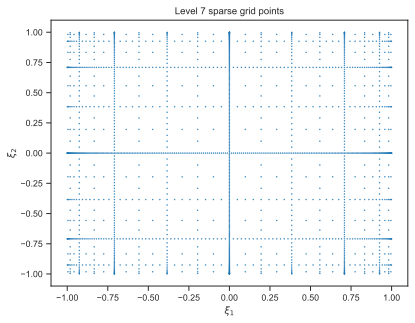

In [72]:
fig, ax = plt.subplots()
ax.plot(xs[:, 0], xs[:, 1], '.', ms=1)
ax.set_title(f"Level {level} sparse grid points");
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$");

Here is how we can do the inner products:

In [73]:
phis = phi(xs)
for i in range(phi.num_basis):
    for j in range(i, phi.num_basis):
        dot_ij = np.einsum("i,i,i->", ws, phis[:, i], phis[:, j])
        print(f"<ψ{i},ψ{j}> \t= {dot_ij:.3f}")

<ψ0,ψ0> 	= 1.000
<ψ0,ψ1> 	= -0.000
<ψ0,ψ2> 	= -0.000
<ψ0,ψ3> 	= 0.000
<ψ0,ψ4> 	= 0.000
<ψ0,ψ5> 	= 0.000
<ψ0,ψ6> 	= -0.000
<ψ0,ψ7> 	= 0.000
<ψ0,ψ8> 	= 0.000
<ψ0,ψ9> 	= -0.000
<ψ0,ψ10> 	= -0.000
<ψ0,ψ11> 	= -0.031
<ψ0,ψ12> 	= -0.000
<ψ0,ψ13> 	= -0.000
<ψ0,ψ14> 	= -0.000
<ψ0,ψ15> 	= 0.000
<ψ1,ψ1> 	= 1.000
<ψ1,ψ2> 	= -0.000
<ψ1,ψ3> 	= -0.000
<ψ1,ψ4> 	= -0.000
<ψ1,ψ5> 	= -0.000
<ψ1,ψ6> 	= -0.000
<ψ1,ψ7> 	= -0.000
<ψ1,ψ8> 	= -0.028
<ψ1,ψ9> 	= 0.000
<ψ1,ψ10> 	= -0.000
<ψ1,ψ11> 	= 0.000
<ψ1,ψ12> 	= -0.000
<ψ1,ψ13> 	= -0.032
<ψ1,ψ14> 	= -0.000
<ψ1,ψ15> 	= -0.000
<ψ2,ψ2> 	= 1.000
<ψ2,ψ3> 	= -0.000
<ψ2,ψ4> 	= -0.000
<ψ2,ψ5> 	= -0.000
<ψ2,ψ6> 	= 0.000
<ψ2,ψ7> 	= -0.028
<ψ2,ψ8> 	= -0.000
<ψ2,ψ9> 	= -0.000
<ψ2,ψ10> 	= -0.000
<ψ2,ψ11> 	= 0.000
<ψ2,ψ12> 	= -0.000
<ψ2,ψ13> 	= -0.000
<ψ2,ψ14> 	= -0.032
<ψ2,ψ15> 	= -0.000
<ψ3,ψ3> 	= 1.000
<ψ3,ψ4> 	= 0.000
<ψ3,ψ5> 	= -0.031
<ψ3,ψ6> 	= 0.000
<ψ3,ψ7> 	= -0.000
<ψ3,ψ8> 	= 0.000
<ψ3,ψ9> 	= -0.000
<ψ3,ψ10> 	= -0.000
<ψ3,ψ11> 	= -0.025
<ψ3,ψ12> 	= 0.000
<ψ3,ψ13

You want the level high enough so that these are accurate to some extent. This looks correct.

## Hermite Polynomials in 2D

Let's do the same thing for normal random variables. 
Here $\Xi_1$ and $\Xi_2$ are independent standard normal random variables and $\Xi = (\Xi_1, \Xi_2)$.

Make the polynomials:

In [74]:
degree1 = 3
phi1 = ojax.make_hermite_polynomial(degree1)
degree2 = 3
phi2 = ojax.make_hermite_polynomial(degree2)

total_degree = 6
phi = ojax.TensorProduct(total_degree, [phi1, phi2])

Let's plot them:

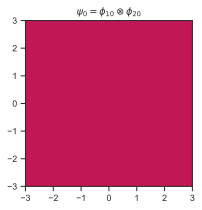

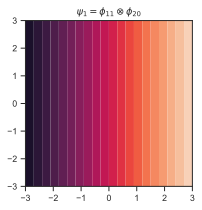

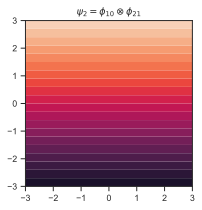

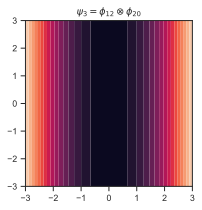

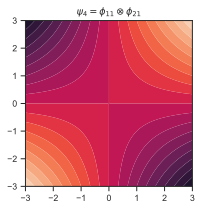

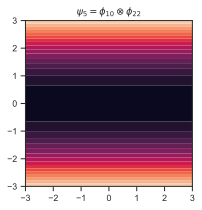

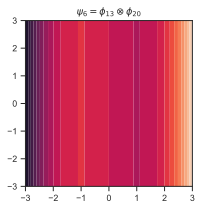

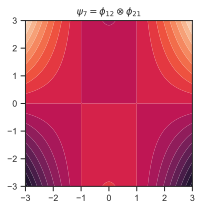

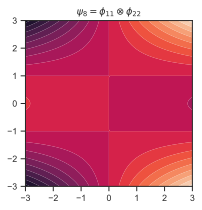

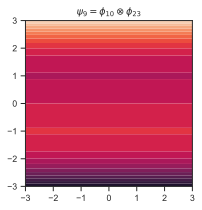

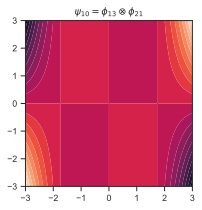

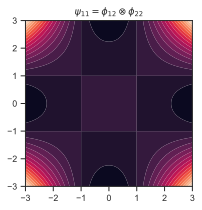

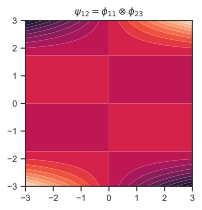

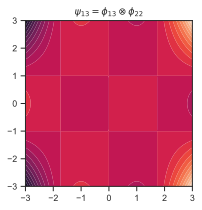

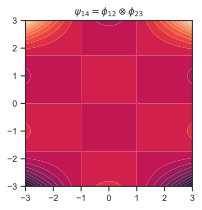

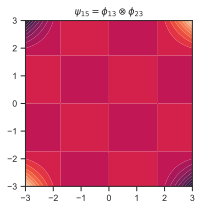

In [75]:
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.stack([X1, X2], axis=-1)
X_flat = np.reshape(X, [-1, 2])
phis = phi(X_flat)
Z = np.reshape(phis, [100, 100, phi.num_basis])

for i in range(phi.num_basis):
  fig, ax = plt.subplots(figsize=(3, 3))
  ax.contourf(X1, X2, Z[:, :, i], levels=20)
  ax.set_title(f"$\psi_{{{i}}} = \phi_{{1{phi.terms[i][0]}}}\otimes \phi_{{2{phi.terms[i][1]}}}$")

Let's test orthogonality.
Here we need also a sparse grid but for Hermite polynomials.

In [76]:
num_dim = 2
level = 6
xs, ws = design.sparse_grid(num_dim, level, 'GH') # Notice that I changed CC to GH
# The normalization below is necessary. I don't have time
# to change the code in py-design.
xs = xs * np.sqrt(2)
ws = ws / np.sqrt(np.pi ** num_dim)

phis = phi(xs)
for i in range(phi.num_basis):
    for j in range(i, phi.num_basis):
        dot_ij = np.einsum("i,i,i->", ws, phis[:, i], phis[:, j])
        print(f"<ψ{i},ψ{j}> \t= {dot_ij:.3f}")

<ψ0,ψ0> 	= 1.000
<ψ0,ψ1> 	= -0.000
<ψ0,ψ2> 	= -0.000
<ψ0,ψ3> 	= 0.000
<ψ0,ψ4> 	= 0.000
<ψ0,ψ5> 	= 0.000
<ψ0,ψ6> 	= -0.000
<ψ0,ψ7> 	= 0.000
<ψ0,ψ8> 	= 0.000
<ψ0,ψ9> 	= -0.000
<ψ0,ψ10> 	= -0.000
<ψ0,ψ11> 	= 0.000
<ψ0,ψ12> 	= -0.000
<ψ0,ψ13> 	= -0.000
<ψ0,ψ14> 	= -0.000
<ψ0,ψ15> 	= -0.000
<ψ1,ψ1> 	= 1.000
<ψ1,ψ2> 	= 0.000
<ψ1,ψ3> 	= -0.000
<ψ1,ψ4> 	= -0.000
<ψ1,ψ5> 	= -0.000
<ψ1,ψ6> 	= -0.000
<ψ1,ψ7> 	= -0.000
<ψ1,ψ8> 	= 0.000
<ψ1,ψ9> 	= 0.000
<ψ1,ψ10> 	= 0.000
<ψ1,ψ11> 	= -0.000
<ψ1,ψ12> 	= -0.000
<ψ1,ψ13> 	= -0.000
<ψ1,ψ14> 	= -0.000
<ψ1,ψ15> 	= -0.000
<ψ2,ψ2> 	= 1.000
<ψ2,ψ3> 	= -0.000
<ψ2,ψ4> 	= -0.000
<ψ2,ψ5> 	= -0.000
<ψ2,ψ6> 	= 0.000
<ψ2,ψ7> 	= 0.000
<ψ2,ψ8> 	= -0.000
<ψ2,ψ9> 	= -0.000
<ψ2,ψ10> 	= -0.000
<ψ2,ψ11> 	= -0.000
<ψ2,ψ12> 	= 0.000
<ψ2,ψ13> 	= -0.000
<ψ2,ψ14> 	= -0.000
<ψ2,ψ15> 	= -0.000
<ψ3,ψ3> 	= 1.000
<ψ3,ψ4> 	= 0.000
<ψ3,ψ5> 	= 0.000
<ψ3,ψ6> 	= 0.000
<ψ3,ψ7> 	= -0.000
<ψ3,ψ8> 	= -0.000
<ψ3,ψ9> 	= -0.000
<ψ3,ψ10> 	= -0.000
<ψ3,ψ11> 	= 0.000
<ψ3,ψ12> 	= -0.000
<ψ3,ψ13> 	

## Dealing with a mix of random variables

Above we had either only uniform or only normal random variables.
If you have mixed versions, you have three choices:

+ Map all random variables to uniform and use the recipe above.
You can do this as follows. Take $\Xi_i$ following a distribution with CDF $F_i$.
Then $\Xi_i = F_i^{-1}(U_i)$, where $U_i$ is a uniform random variable in $[0,1]$. Then work with $U_i$.

+ Use a sparse grid quadrature rule that is based on a tensor product of nested quadrature rules for each random variable. I have not implemented this due to lack of time. But it is implemented in the package [chaospy](https://chaospy.readthedocs.io/en/master/). The only problem with chaospy is that it is not in `jax`.

## Dealing with Random Variables that are Not Independent

If you have a multi-variate normal:

$$
\Xi \sim N(\mu, \Sigma),
$$

you can use the fact that:

$$
\Xi = \mu + L Z,
$$

where

$$
\Sigma = L L^T,
$$

and $Z$ is a standard normal random variable.
Furthermore, you can go to uniform random variables by using the CDF of the normal distribution.
That is, we can write:

$$
\Xi = \mu + L \Phi^{-1}(U),
$$

where $U$ a vector of independent uniform random variables in $[-1,1]$.

For a more general distribution, you have to use the Rosenblatt transformation.
More about it [here](https://www.sciencedirect.com/topics/engineering/rosenblatt-transformation).